# Recommender System - Movie Lens Hybrid Model.

###### Links: [MovieLens (GroupLens)](https://grouplens.org/datasets/movielens/latest/)  |  [Article (TowardsDataScience)](https://towardsdatascience.com/modern-recommendation-systems-with-neural-networks-3cc06a6ded2c)

# Step 0: Setup

### Import packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

### Import data & Data Representation

In [ ]:
# Movies
dtf_movies = pd.read_csv("movies.csv")
dtf_movies = dtf_movies.replace('-','', regex = True)

dtf_movies = dtf_movies[~dtf_movies["genres"].isna()]
dtf_movies["product"] = range(0,len(dtf_movies))
dtf_movies["title"] = dtf_movies["title"].replace('-','')
dtf_movies["title"] = dtf_movies["title"].apply(lambda x: re.sub(r'\(\D+\)', "", x))
dtf_movies["name"] = dtf_movies["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())

 

dtf_movies["date"] = dtf_movies["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").strip()) 
                                                             if "(" in x else np.nan)                                                       

## add features
dtf_movies["date"] = dtf_movies["date"].fillna(9999)
dtf_movies["old"] = dtf_movies["date"].apply(lambda x: 1 if x < 2000 else 0)

dtf_movies

,movieId,title,genres,product,name,date,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1
...,...,...,...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),58093,The Great Glinka,1946.0,1
58094,193878,Les tribulations d'une caissière (2011),Comedy,58094,Les tribulations d'une caissière,2011.0,0
58095,193880,Her Name Was Mumu (2016),Drama,58095,Her Name Was Mumu,2016.0,0
58096,193882,Flora (2017),Adventure|Drama|Horror|SciFi,58096,Flora,2017.0,0


In [ ]:
# Users
dtf_users = pd.read_csv("ratings1.csv")

dtf_users["user"] = dtf_users["userId"].apply(lambda x: x-1)

dtf_users["timestamp"] = dtf_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
dtf_users["daytime"] = dtf_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
dtf_users["weekend"] = dtf_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

dtf_users = dtf_users.merge(dtf_movies[["movieId","product"]], how="left")
dtf_users = dtf_users.rename(columns={"rating":"y"})

dtf_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,307,3.5,2009-10-27 21:00:21,0,0,0,304
1,1,481,3.5,2009-10-27 21:04:16,0,0,0,477
2,1,1091,1.5,2009-10-27 21:04:31,0,0,0,1069
3,1,1257,4.5,2009-10-27 21:04:20,0,0,0,1229
4,1,1449,4.5,2009-10-27 21:01:04,0,0,0,1414
...,...,...,...,...,...,...,...,...
598402,6063,3624,5.0,2011-05-01 07:29:34,6062,1,1,3534
598403,6063,3827,4.0,2011-05-01 07:31:03,6062,1,1,3736
598404,6063,4321,4.5,2011-05-01 07:29:46,6062,1,1,4227
598405,6063,5065,3.0,2011-05-01 07:32:58,6062,1,1,4970


In [ ]:
# select only useful columns
dtf_movies = dtf_movies[["product","name","old","genres"]].set_index("product")
dtf_movies.head()

,name,old,genres
product,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [ ]:
# extract context
dtf_context = dtf_users[["user","product","daytime","weekend"]]
dtf_context.head()

,user,product,daytime,weekend
0,0,304,0,0
1,0,477,0,0
2,0,1069,0,0
3,0,1229,0,0
4,0,1414,0,0


In [ ]:
dtf_users = dtf_users[["user","product","y"]]
dtf_users.head()

,user,product,y
0,0,304,3.5
1,0,477,3.5
2,0,1069,1.5
3,0,1229,4.5
4,0,1414,4.5


# Step 1: Data Analysis

###### Products

In [ ]:
tags = [i.split("|") for i in dtf_movies["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
print(columns)

['SciFi', 'Children', 'Western', 'Thriller', 'Action', 'Musical', 'Drama', 'Horror', 'Animation', 'Adventure', 'Documentary', 'IMAX', 'Fantasy', 'Comedy', 'Crime', 'War', 'FilmNoir', 'Mystery', 'Romance']


In [ ]:
for col in columns:
    dtf_movies[col] = dtf_movies["genres"].apply(lambda x: 1 if col in x else 0)
dtf_movies.head()

,name,old,genres,SciFi,Children,Western,Thriller,Action,Musical,Drama,...,Adventure,Documentary,IMAX,Fantasy,Comedy,Crime,War,FilmNoir,Mystery,Romance
product,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy,0,1,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
1,Jumanji,1,Adventure|Children|Fantasy,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,Grumpier Old Men,1,Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,Waiting to Exhale,1,Comedy|Drama|Romance,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,Father of the Bride Part II,1,Comedy,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


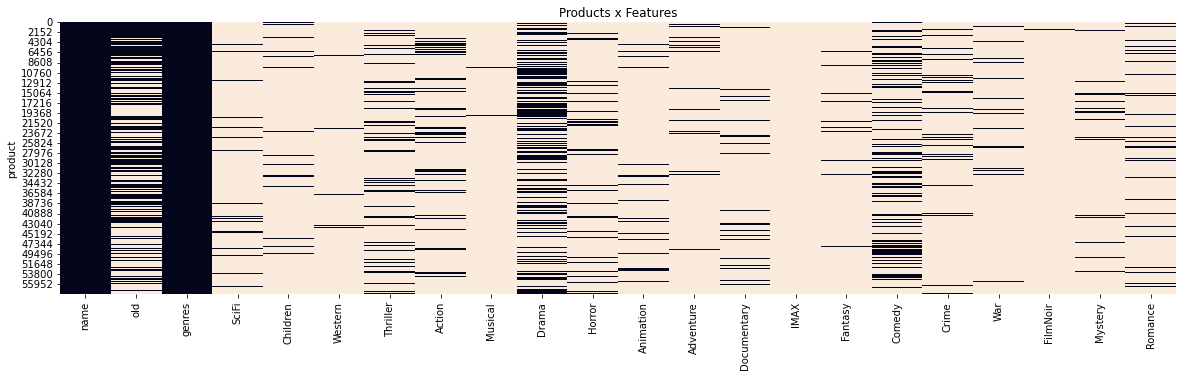

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_movies==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

###### Users

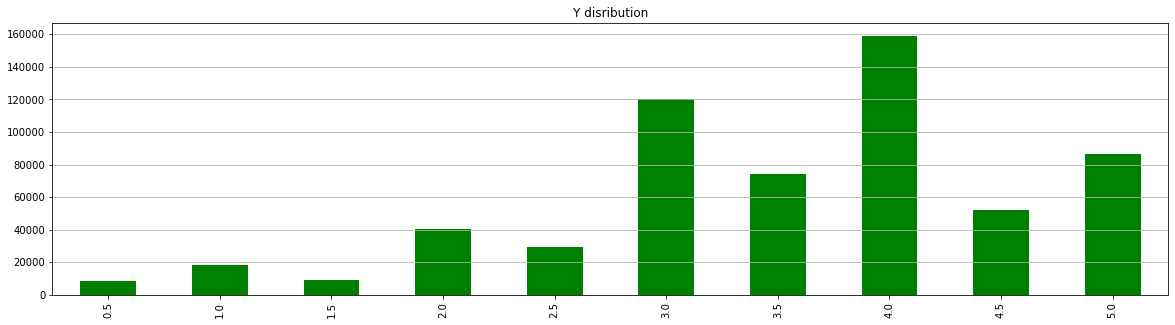

In [ ]:
dtf_users["y"].value_counts().sort_index().plot(kind="bar", color="green", title="Y disribution", 
                                                figsize=(20,5)).grid(axis='y')
plt.show()

In [ ]:
dtf_users.head()

,user,product,y
0,0,304,3.5
1,0,477,3.5
2,0,1069,1.5
3,0,1229,4.5
4,0,1414,4.5


## Pivioting Users Dataframe, However as my ram is just 8Gb and the dataset is too huge, Pivioting has to be done chunk vise.

In [ ]:
# chunk_size = 50000
# chunks = [x for x in range(0, dtf_users.shape[0], chunk_size)]

# for i in range(0, len(chunks) - 1):
#     print(chunks[i], chunks[i + 1] - 1)

In [ ]:
# tmp = dtf_users.copy()

# dtf_users = pd.concat([tmp.iloc[ chunks[i]:chunks[i + 1] - 1 ].pivot_table(index='user', columns='product', values='y') for i in range(0, len(chunks) - 1)])


In [ ]:
tmp = dtf_users.copy()
dtf_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(dtf_movies.index) - set(dtf_users.columns))
for col in missing_cols:
    dtf_users[col] = np.nan
dtf_users = dtf_users[sorted(dtf_users.columns)]
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,58088,58089,58090,58091,58092,58093,58094,58095,58096,58097
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,4.0,NaN,NaN,2.0,4.5,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


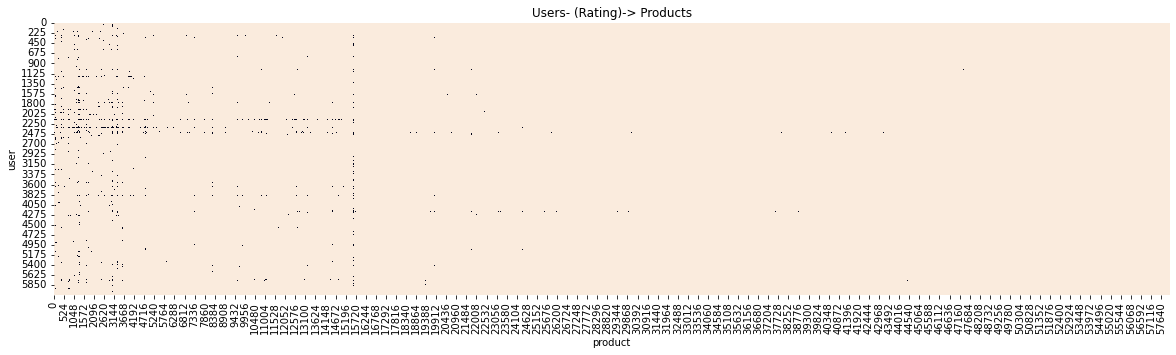

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_users.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users- (Rating)-> Products")
plt.show()

# Step 2: Preprocessing
- Scaling
- Partitioning

## Scaling

In [ ]:
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), 
                         columns=dtf_users.columns, index=dtf_users.index)
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,58088,58089,58090,58091,58092,58093,58094,58095,58096,58097
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.888889,0.888889,NaN,NaN,0.666667,0.9375,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Partitioning

In [ ]:
split = int(0.8*dtf_users.shape[1])
split

46478

In [ ]:
# Train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

non-null data: 594514


product,0,1,2,3,4,5,6,7,8,9,...,46468,46469,46470,46471,46472,46473,46474,46475,46476,46477
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.888889,0.888889,NaN,NaN,0.666667,0.9375,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 3893


product,46478,46479,46480,46481,46482,46483,46484,46485,46486,46487,...,58088,58089,58090,58091,58092,58093,58094,58095,58096,58097
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 3 - Baseline Model->Content-Based Model

In [ ]:
# Select a user
i = 1
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
test.head()

train: 15 | test: 0


,y
product,
46478,NaN
46479,NaN
46480,NaN
46481,NaN
46482,NaN


In [ ]:
# add all products in test but empty
tmp = test.copy()
tmp["y"] = np.nan
train = train.append(tmp)
train.tail()

,y
product,
58093,NaN
58094,NaN
58095,NaN
58096,NaN
58097,NaN


In [ ]:
# Model
usr = train[["y"]].fillna(0).values.T
prd = dtf_movies.drop(["name","genres"],axis=1).values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 58098)  x  Products (58098, 20)


In [ ]:
# Numpy
import numpy as np

## usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = np.dot(usr, prd)
## normalize
weights = usr_ft / usr_ft.sum()
## predicted rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = np.dot(weights, prd.T)

test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,product,y,yhat


In [ ]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [ ]:
print("--- user", i, "---")

top = 5
y_test = test.sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test.sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: []
predicted: []
true positive: 0 (0.0%)
mrr: nan


In [ ]:
test.merge(
        dtf_movies[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,product,y,yhat,name,old,genres
product,,,,,,


# Step 4: Model Desing & Testing for -> Collaborative Filtering

## Data

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,304,0.833333
1,0,477,0.812500
2,0,1069,0.562500
3,0,1229,0.944444
4,0,1414,0.944444


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,13,51097,1.000000
1,35,49942,0.944444
2,35,50069,0.800000
3,35,51015,0.833333
4,47,46663,0.666667


## Model Design

In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
print("Collaborative Filetering")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Collaborative Filetering
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xusers_in (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
xproducts_in (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
xusers_emb (Embedding)          (None, 1, 50)        303150      xusers_in[0][0]                  
__________________________________________________________________________________________________
xproducts_emb (Embedding)       (None, 1, 50)        2904900     xproducts_in[0][0]               
____________

## Train / Test

In [ ]:

def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

Instructions for updating:
Use tf.cast instead.


2022-07-25 20:48:37.241467: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2
2022-07-25 20:48:37.244480: I tensorflow/core/common_runtime/process_util.cc:71] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


KeyboardInterrupt: 

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

## Evaluate

In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

In [ ]:
test[test["user"]==i].merge(
        dtf_movies[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

### 5 - Model Desing & Testing (Neural Collaborative Filtering)

###### Data

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

###### Model Design

In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
print("Collaborative Filtering")
model.summary()

###### Train / Test

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

###### Evaluate

In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

In [ ]:
test[test["user"]==i].merge(
        dtf_movies[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

### 6 - Hybrid Model

###### Data

In [ ]:
# Extra data
features = dtf_movies.drop(["genres","name"], axis=1).columns
print(features)

context = dtf_context.drop(["user","product"], axis=1).columns
print(context)

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
train = train.merge(dtf_movies[features], how="left", left_on="product", right_index=True)

## add context
train = train.merge(dtf_context, how="left")

train.head()

In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
test = test.merge(dtf_movies.drop(["genres","name"], axis=1), how="left", left_on="product", right_index=True)

## add context
test[context] = 0 #--> simulate production for a weekday night
#test = test.merge(dtf_context, how="left") #--> use test set

test.head()

###### Model Design

In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
print("Hybrid_Model")
model.summary()

###### Train / Test

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

In [ ]:
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test

In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))